# Worksheet 5: Model Asssumptions and Causality

#### Lecture and Tutorial Learning Goals:
After completing this week's lecture and tutorial work, you will be able to:

1. Describe heteroscedasticity and the problem it presents to generative modeling.
2. Write a computer script to assess whether heteroscedasticity in a given data set, and if so, use practical solutions to manage it.
3. Describe colinearity and the problem it presents to generative modeling.
4. Write a computer script to assess whether collinearity exists between input variables in a given data set, and if so, use practical solutions to manage it.
5. Discuss why a data scientist may need to consult a domain expert when examining model assumptions.
6. Give an example of a real problem that aims to test a causal relationship between variables.
7. Give an example of a real problem the model can only establish an association between the response and the input variables.
8. Discuss how the desired goal of generative modelling is usually to make causal claims however we cannot often/easily do so (e.g., in particular in the context of observational studies).
9. Discuss the role of confounders in causal inference.

In [1]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(faux)
source("tests_worksheet_05.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



************
Welcome to faux. For support and examples visit:
https://debruine.github.io/faux/
- Get and set global package options with: faux_options()
************


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from

# PART I

## Model Assumptions

When we analyze a dataset to respond to a question of interest, we make several assumptions. However, in practice, many of these assumptions may not be true posing many problems in our analysis. The most common problems that we may encounter are:

1. the relation between the response and the input variable(s) is not linear
2. error terms are correlated (not independent as we assumed)
3. error terms do not have a common variance (not identically distributed as we assumed)
4. error terms are not Normally distributed (not a strong assumption but convenient)
5. (some) input variables are correlated

"In practice, identifying and overcoming these problems is as much an
art as a science" (from ISL, Section 3.3.3). 

## 1. Warm Up Questions

**Question 1.1**
<br>{points: 1}

True or false?

The results of the test of hypotheses given by `lm()` are only valid if we assume that the errors in the linear regression model are (exactly) Normally distributed.

*Assign your answer to an object called `answer1.1`. Your answer should be either "true" or "false", surrounded by quotes.*

In [2]:
# answer1.1 <- ...

# your code here
answer1.1 <- "false"

In [3]:
test_1.1()

Test passed 🌈
Test passed 🥳
Test passed 🎊
[1] "Success!"


**Question 1.2**
<br>{points: 1}

True or false?

In a linear regression, multicollinearity refers to the correlation between each input variable with the response variable.

*Assign your answer to an object called `answer1.2`. Your answer should be either "true" or "false", surrounded by quotes.*

In [4]:
# answer1.2 <- ...

# your code here
answer1.2 <- "false"

In [5]:
test_1.2()

Test passed 😸
Test passed 🎉
Test passed 🥳
[1] "Success!"


**Question 1.3**
<br>{points: 1}

True or false?

In the presence of multicollinearity in a multiple linear regression (MLR), it can be difficult to determine how collinear variables are separately associated with the response.

*Assign your answer to an object called `answer1.3`. Your answer should be either "true" or "false", surrounded by quotes.*

In [6]:
# answer1.3 <- ...

# your code here
answer1.3 <- "true"

In [7]:
test_1.3()

Test passed 🌈
Test passed 🌈
Test passed 🎊
[1] "Success!"


**Question 1.4**
<br>{points: 1}

True or false?

Multicollinearity inflates the estimates of the standard errors of the least squares (LS) estimators of the regression coefficients.

*Assign your answer to an object called `answer1.4`. Your answer should be either "true" or "false", surrounded by quotes.*

In [8]:
# answer1.4 <- ...

# your code here
answer1.4 <- "true"

In [9]:
test_1.4()

Test passed 🥳
Test passed 🎊
Test passed 😀
[1] "Success!"


**Question 1.5**
<br>{points: 1}

True or false?

The assumption that all the error terms have the same variance does not affect the estimates of the standard error of the LS estimators.

*Assign your answer to an object called `answer1.5`. Your answer should be either "true" or "false", surrounded by quotes.*

In [10]:
# answer1.5 <- ...

# your code here
answer1.5 <- "false"

In [11]:
test_1.5()

Test passed 🎊
Test passed 😸
Test passed 🥇
[1] "Success!"


## 2. Violations of model assuptions


In the following problems we will explore how violations of model assumptions affect our estimation and analyses *using simulated data*. 

> The advantage of simulating data is that we have full control over the data generating process so **we know the true parameters** and we can examine problems in a control way. 

Real datasets are rich and interesting but usually contain many (unknown) problems and we don't know the true parameters to assess the performance of our estimation and analyses. 

### Bechmark model

**Question 2.0**
<br>{points: 1}

Let's start by generating a sample of size $n = 1000$ from a data generating process that *fullfills all the assumptions* of classical least square estimation in linear regression.

In this problem we generate data from a continuous response, one continuous input variable and one binary input variable. We call this first sample `sample_model_1`.

That is, for $i = 1, \dots, n$:

$$Y_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \varepsilon_i$$ 

where the error terms $\varepsilon_i \sim \mathcal{N}(0, \sigma^2 = 4)$ are independent and identically distributed. Assume that $X_{1}$ is uniformly distributed between 2 and 5, and $X_{2}$ is a binary random variable with levels "A" and "B" (with equal probabilty).

Generate a response variable using these model assumptions and true (population) regression coefficients $\beta_0$, $\beta_1$, and $\beta_2$ equal to $10$, $8$, and $5$, respectively. 

> **Heads up**: the distributions used to generate the input variables do not affect the results of our analysis. 

Note that the columns of `sample_model_1` are:

- `x_1`: the values of the continuous input $X_{i1}$
- `x_2`: the levels of the discrete input $X_{i2}$
- `y`: the sampled response values $Y_i$

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [12]:
sample_size <- 1000

set.seed(123) # DO NOT CHANGE!

# sample_model_1 <- tibble(
#   x_1 = runif(n = ..., ..., ...),
#   x_2 = factor(rbinom(n = ..., size = 1, prob = 0.5), labels=c("A", "B"))
# )
# sample_model_1$y <- ... + 8 * sample_model_1$x_1 + 5 * ifelse(sample_model_1$x_2 == "B", 1, 0) +
#   rnorm(n = ..., mean = ..., sd = ...)
# head(sample_model_1)

# your code here
sample_model_1 <- tibble(
  x_1 = runif(n = 1000, min = 2, max = 5),
  x_2 = factor(rbinom(n = 1000, size = 1, prob = 0.5), labels=c("A", "B"))
)
sample_model_1$y <- 10 + 8 * sample_model_1$x_1 + 5 * ifelse(sample_model_1$x_2 == "B", 1, 0) +
  rnorm(n = 1000, mean = 0, sd = 2)
head(sample_model_1)

x_1,x_2,y
<dbl>,<fct>,<dbl>
2.862733,A,30.91026
4.364915,B,47.83941
3.226931,A,35.77949
4.649052,B,51.92807
4.821402,B,48.47253
2.136669,A,29.17450


In [13]:
test_2.0()

Test passed 🥳
Test passed 🌈
Test passed 🥳
Test passed 🥇
Test passed 🎊
Test passed 🎊
[1] "Success!"


**Question 2.1**
<br>{points: 1}

Use the simulated `sample_model_1` to estimate the regression parameters $\beta_0$, $\beta_1$, and $\beta_2$ and elements to make inference using hypothesis tests. Use the functions `lm()` and assign the results to the object `model_1`.

Obtain the estimated coefficients, their standard errors, corresponding $p$-values, $95\%$ confidence intervals using `tidy()`. Store the results in `model_1_results`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [14]:
# model_1 <- ...(..., ...)

# model_1_results <- ...(..., ...) %>% mutate_if(is.numeric, round, 2)
# model_1_results

# your code here
model_1 <- lm(y ~ x_1 + x_2 , data = sample_model_1)

model_1_results <- tidy(model_1, conf.int = 0.95) %>% mutate_if(is.numeric, round, 2)
model_1_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),10.08,0.28,36.47,0,9.53,10.62
x_1,8.03,0.07,108.25,0,7.88,8.17
x_2B,4.84,0.13,37.88,0,4.59,5.09


In [15]:
test_2.1()

Test passed 🥇
Test passed 🎊
Test passed 🥳
Test passed 🥳
Test passed 🥳
Test passed 🥇
Test passed 😸
Test passed 😀
Test passed 🥇
Test passed 😀
[1] "Success!"


#### Note that the estimates $\hat{\beta}_0$,  $\hat{\beta}_1$, and $\hat{\beta}_2$ in `model_1` are close to the true population parameters (less than 2 standard errors away). At least for this sample, all 95% confidence intervals contain the true parameters that we've used to generate the data.

> **Heads up**: in general, we don't know the true parameters to make this type of assessment.

> **Heads up**: even with simulated data, the estimated CI may not contain the true parameters. Why??

### Heteroscedasticity

In the previous case, we assume that the error terms were independent and identically distributed. *What would happen if this assumption is violated in the data??*

In particular, we will focus on a problem known as *heteroscedasticity*.

In the next question, we are going to simulate data from a *data generating process with heteroscedasticity* and use `lm` to estimate the coefficients of the MLR ignoring that the error terms are heteroscedastic.

**Question 2.2**
<br>{points: 1}

We generate a sample of size $n = 1000$ from a data generating process with the following characteristics:

For $i = 1, \dots, n$:

$$Y_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \varepsilon_i$$ 

where the error terms $\varepsilon_i \sim \mathcal{N}(0, \sigma_i^2 = (X_{i1})^4)$. The variables $X_{i1}$ and $X_{i2}$ are generated as in **Question 2.0**.

> **There is heteroscedasticity (i.e., the value of $\sigma_i^2$ is different for each observation).**

As before, let the true (population) regression terms $\beta_0$, $\beta_1$, and $\beta_2$ be $10$, $8$, and $5$. 

Call this new sample `sample_model_2`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [16]:
set.seed(321) # DO NOT CHANGE!

# sample_size = ...

# sample_model_2 <- tibble(
#   x_1 = runif(n = ..., ..., ...),
#   x_2 = factor(rbinom(n = ..., size = ..., prob = ...), labels=c("A", "B"))
# )
# sample_model_2$y <- ... + ... * sample_model_2$... + 5 * ifelse(sample_model_2$... == "B", 1, 0) +
#   rnorm(n = ..., mean = ..., sd = (sample_model_2$...)^2)
# head(sample_model_2)

# your code here
sample_size = 1000

sample_model_2 <- tibble(
  x_1 = runif(n = sample_size, min = 2, max = 5),
  x_2 = factor(rbinom(n = 1000, size = 1, prob = 0.5), labels=c("A", "B"))
)
sample_model_2$y <- 10 + 8 * sample_model_2$x_1 + 5 * ifelse(sample_model_2$x_2 == "B", 1, 0) +
  rnorm(n = sample_size, mean = 0, sd = (sample_model_2$x_1)^2)
head(sample_model_2)

x_1,x_2,y
<dbl>,<fct>,<dbl>
4.867681,A,13.48532
4.811857,B,23.73002
2.714661,A,42.05411
2.765221,A,32.34095
3.171536,A,54.49148
3.023540,B,29.03126


In [17]:
test_2.2()

Test passed 🌈
Test passed 🥇
Test passed 🥇
Test passed 🥳
Test passed 😀
Test passed 🎉
[1] "Success!"


**Question 2.3**
<br>{points: 1}

Use the simulated `sample_model_2` to estimate the regression parameters $\beta_0$, $\beta_1$, and $\beta_2$ and elements to make inference using hypothesis tests. 

*Ignore the heteroscedasticity of the data generating process* and use the function `lm()` to estimate the regression parameters. Assign the results to the object `model_2`.

Obtain the estimated coefficients, their standard errors, corresponding $p$-values, $95\%$ confidence intervals using `tidy()`. Store the results in `model_2_results`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [18]:
# model_2 <- ...(..., ...)

# model_2_results <- ...(..., ...) %>% mutate_if(is.numeric, round, 2)
# model_2_results

# your code here
model_2 <- lm(y ~ x_1 + x_2, data = sample_model_2)

model_2_results <- tidy(model_2, conf.int = 0.95) %>% mutate_if(is.numeric, round, 2)
model_2_results



term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),10.56,1.97,5.35,0,6.69,14.43
x_1,7.76,0.53,14.69,0,6.72,8.80
x_2B,5.77,0.92,6.28,0,3.97,7.58


In [19]:
test_2.3()

Test passed 🥇
Test passed 😀
Test passed 🥇
Test passed 😀
Test passed 🎊
Test passed 🥇
Test passed 😸
Test passed 😀
Test passed 🥇
Test passed 😸
[1] "Success!"


**Question 2.4**
<br>{points: 1}

Recall that the true population values of $\beta_0$, $\beta_1$, and $\beta_2$ are $10$, $8$, and $5$ respectively.  What of the following consequences of ignoring the heteroscedasticity of the data generating process is true? 

*Tip*: `lm` assumes that the errors are *iid* as in `sample_model_1`. Thus, you can also use `model_1_results` as a benchmark.

**A.** The estimates $\hat{\beta}_0$,  $\hat{\beta}_1$, and $\hat{\beta}_2$ in `model_2_results` are still similar to the true population parameters but their estimated standard errors are inflated.

**B.** The 95% confidence intervals of the regression coefficients are not affected by the heteroscedasticity of the data generating process.


*Assign your answer to an object called `answer2.4`. Your answer should be one of `"A"` or `"B"` surrounded by quotes.*

In [20]:
# answer2.4 <- 

# your code here
answer2.4 <- "A"

In [21]:
test_2.4()

Test passed 🎊
Test passed 🎊
Test passed 🥇
[1] "Success!"


#### Detecting heteroscedasticity

When we don't have simulated data, we can (graphically) diagnose heteroscedasticity by comparing the fitted values to the **residuals**. 

<font color="blue">**Diagnosis rule**</font>

<font color="blue">If the errors are homoscedastic (equal variance), the residuals should show equal variation for all fitted values. </font>

Let's take a look at these plots for both cases simulated before: `model_1` (homoscedastic case) versus `model_2` (heteroscedastic case). We can obtain both plots via the function `plot()`.

*Run the cell below before continuing.*

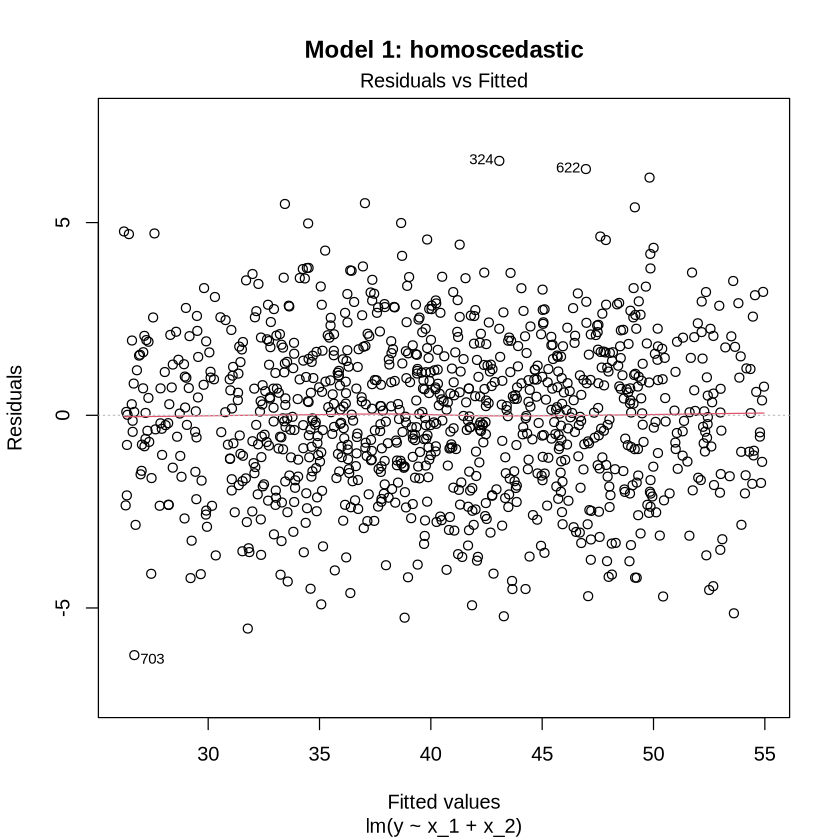

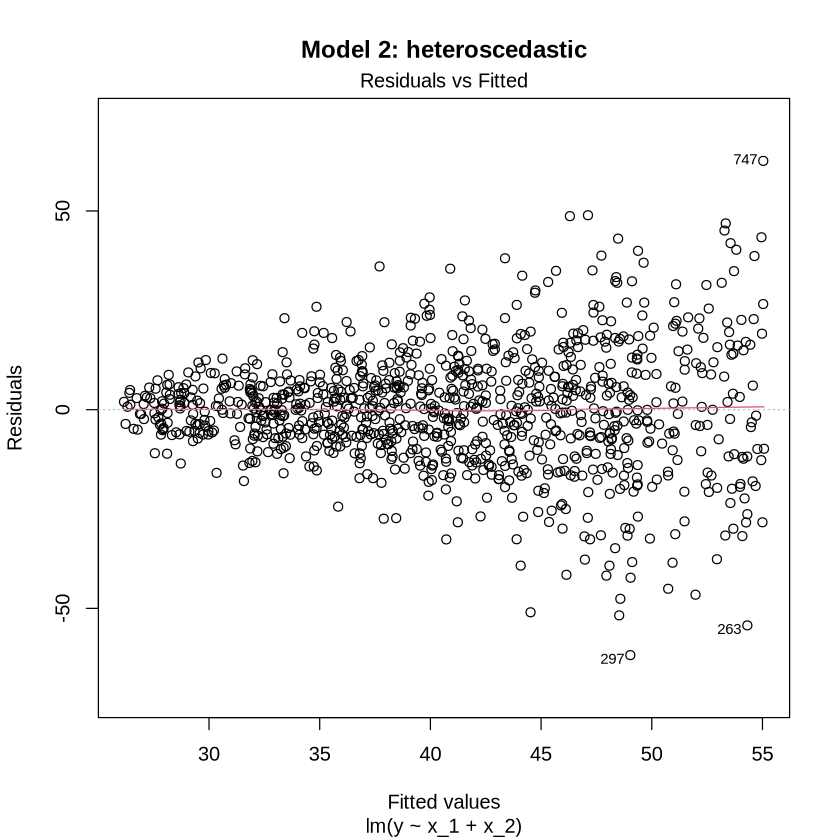

In [22]:
plot(model_1, 1, main = "Model 1: homoscedastic")
plot(model_2, 1, main = "Model 2: heteroscedastic")

**Question 2.5**
<br>{points: 1}

What is the difference between both plots of residuals versus fitted values?

**A.** There is no difference between both plots; their respective clouds of points look uniformly similar.

**B.** The diagnostic plot of `model_1` shows a uniform and more scattered cloud of points than `model_2`. The cloud of points in `model_2` shows a clear funnel shape, indicating a non-constant variance.

**C.** The diagnostic plot of `model_2` shows a uniform and more scattered cloud of points than `model_1`. The cloud of points in `model_1` shows a clear funnel shape, indicating a non-constant variance.

*Assign your answer to an object called `answer2.5`. Your answer should be one of `"A"`, `"B"`, or `"C"` surrounded by quotes.*

In [23]:
# answer2.5 <- 

# your code here
answer2.5 <- "B"

In [24]:
test_2.5()

Test passed 🌈
Test passed 🌈
Test passed 😸
[1] "Success!"


### Normality

Another assumption commonly made in linear regression is that the error terms are Normally distributed. *What would happen if this assumption is violated??*. 

In the next question, we are going to simulate data using a data generating process with non-normal errors and use `lm` to estimate the coefficients of the MLR.

**Question 2.6**
<br>{points: 1}

For $i = 1, \dots, 1000$:

$$Y_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \varepsilon_i,$$

where the error terms are independent and identically distributed from a Uniform distribution, $\varepsilon_i \sim \mathrm{U}(-10,10)$. The variables $X_{i1}$ and $X_{i2}$ are generated as in **Question 2.0**.

As before, let the true (population) regression terms $\beta_0$, $\beta_1$, and $\beta_2$ be $10$, $8$, and $5$, respectively, and the sample size $n=1000$.

Call this new sample `sample_model_3`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [25]:
set.seed(654) # DO NOT CHANGE!

# sample_size = ...

# sample_model_3 <- tibble(
#   x_1 = runif(n = ..., ..., ...),
#   x_2 = factor(rbinom(n = ..., size = ..., prob = ...), labels=c("A", "B"))
# )
# sample_model_3$y <- ... + .. * sample_model_3$... + 5 * ifelse(sample_model_3$... == "B", 1, 0) +
# runif(n = ..., ..., ...)
# head(sample_model_3)

# your code here
sample_size = 1000

sample_model_3 <- tibble(
  x_1 = runif(n = sample_size, min = 2, max = 5),
  x_2 = factor(rbinom(n = sample_size, size = 1, prob = 0.5), labels=c("A", "B"))
)
sample_model_3$y <- 10 + 8 * sample_model_3$x_1 + 5 * ifelse(sample_model_3$x_2 == "B", 1, 0) +
runif(n = sample_size, min = -10, max = 10)
head(sample_model_3)

x_1,x_2,y
<dbl>,<fct>,<dbl>
2.670597,A,38.22318
4.238762,A,45.76366
3.045133,A,29.51636
2.199414,A,20.23354
4.863350,A,48.57999
2.626027,B,28.60043


In [26]:
test_2.6()

Test passed 😸
Test passed 🥇
Test passed 🎉
Test passed 🌈
Test passed 🥇
Test passed 🥳
[1] "Success!"


**Question 2.7**
<br>{points: 1}

Use the simulated `sample_model_3` to estimate the regression parameters $\beta_0$, $\beta_1$, and $\beta_2$ and elements to make inference using hypothesis tests. 

Use the function `lm()` to estimate the regression parameters. Assign the results to the object `model_3`.

Obtain the estimated coefficients, their standard errors, corresponding $p$-values, $95\%$ confidence intervals using `tidy()`. Store the results in `model_3_results`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [27]:
# model_3 <- ...(..., ...)

# model_3_results <- ...(..., ...) %>% mutate_if(is.numeric, round, 2)
# model_3_results

# your code here
model_3 <- lm(y ~ x_1 + x_2, data = sample_model_3)

model_3_results <- tidy(model_3, conf.int = 0.95) %>% mutate_if(is.numeric, round, 2)
model_3_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),9.83,0.75,13.14,0,8.36,11.30
x_1,8.00,0.21,38.77,0,7.60,8.41
x_2B,5.53,0.36,15.49,0,4.83,6.24


In [28]:
test_2.7()

Test passed 🎉
Test passed 🌈
Test passed 🌈
Test passed 🎉
Test passed 🌈
Test passed 🥳
Test passed 🥇
Test passed 😀
Test passed 😸
Test passed 🌈
[1] "Success!"


#### Note that the estimate of the regression parameters are not heavily affected by this problem but the SE are large. 

The distributions of the test statistics such as the $t$ or the $F$-statistics rely on the normality of the $\varepsilon_i$'s, unless the sample size $n$ is large enough in which case their distribution can be approximated using asymptotic results. 

#### In this case, the sample size is large so, according to the CLT, the sampling distributions when $\sigma$ is known is approximately Normal. 

> **Important note**: `lm` *assumes* that either the errors are Normal or the conditions of the CLT are met!! Regardless, `lm` assumes that the sampling distribution can be approximated by a $t$-Student distribution. It is *your* job to check these assumptions!

#### Diagnostic plots

A $Q$-$Q$ plot and the histogram of residuals are graphical tools that help us to assess the normality assumption.

Let us compare these plots for `model_1` (with Normal errors) and `model_3` (with non-Normal errors). We can obtain both $Q$-$Q$ plots via the function `plot()` and the histograms using `hist()`.

*Run the cell below before continuing.*

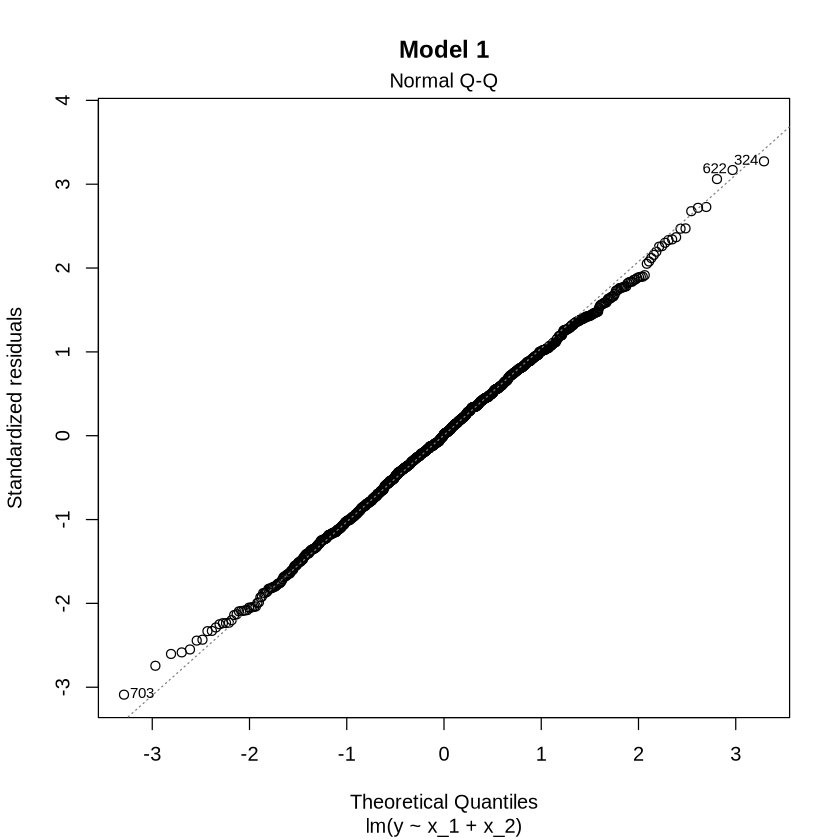

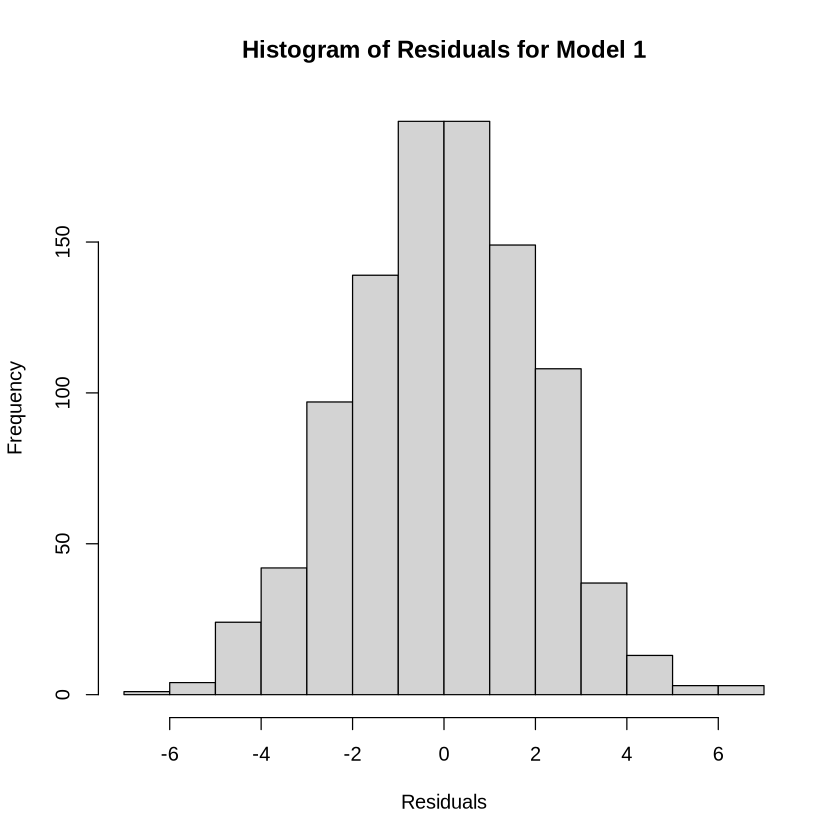

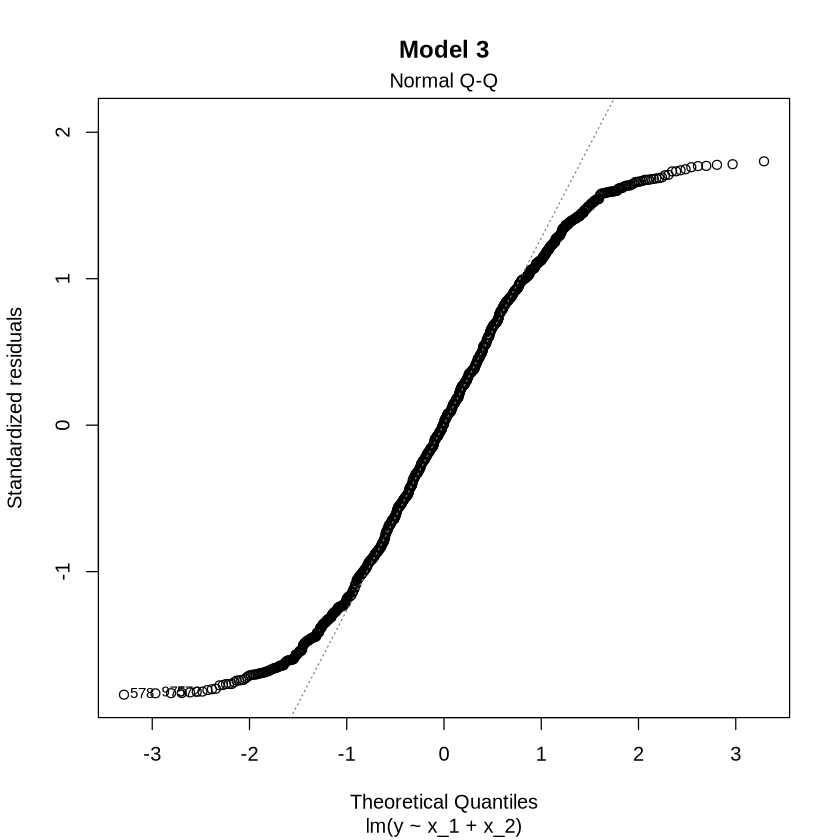

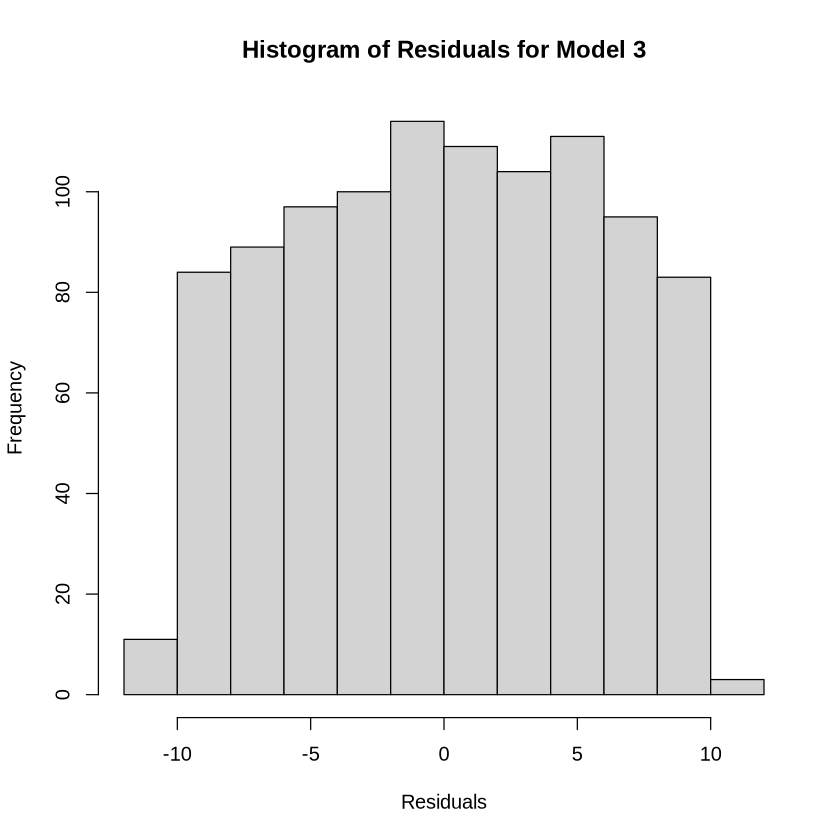

In [29]:
plot(model_1, 2, main = "Model 1")
hist(residuals(object = model_1),
  breaks = 10,
  main = "Histogram of Residuals for Model 1",
  xlab = "Residuals"
)

plot(model_3, 2, main = "Model 3")
hist(residuals(object = model_3),
  breaks = 10,
  main = "Histogram of Residuals for Model 3",
  xlab = "Residuals"
)

**Question 2.8**
<br>{points: 1}


What is the difference between both pairs plots corresponding to `model_1` and `model_3`?

**A.** There are no differences between both pairs of plots, suggesting that both models fulfil the normality assumption.

**B.** For `model_3`, most of the points lie on the 45° degree dotted line of the $Q$-$Q$ plot suggesting that the errors are normally distributed. 

**C.** For `model_1`, most of the points lie on the 45° degree dotted line of the $Q$-$Q$ plot suggesting that the errors are normally distributed. 

**D.** The histogram of the residuals of `model_3` is similar to that of the residuals of `model_1`. 

*Assign your answer to an object called `answer2.8`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"`, surrounded by quotes.*

In [30]:
# answer2.8 <- 

# your code here
answer2.8 <- "C"

In [31]:
test_2.8()

Test passed 😀
Test passed 🌈
Test passed 🎊
[1] "Success!"


### Multicollinearity

A common problem in real data occurs when the input variables are correlated. This problem is known as multicollinearity. In this section we will simulate correlated input variables to understand how this problem affects the sampling distribution of the least squares regression parameter estimators.

In this exercise, we will generate 1000 samples of size $n = 100$ from the following data generating process:

For $i = 1, \dots, n$,

$$Y_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \varepsilon_i$$ 

where the error terms $\varepsilon_i \sim \mathcal{N}(0, \sigma^2 = 4)$ are independent and identically distributed, and $X_{1}$ and $X_{2}$ are two continuous correlated input variables. 

Assume that all the true (population) regression terms $\beta_0$, $\beta_1$, and $\beta_2$ are equal to $10$. 

**Note**: note that $n$ and the regression coefficients are different in this problem.

**Question 2.9**
<br>{points: 1}

First, let's learn how to generate correlated inputs $X_{1}$ and $X_{2}$ from a bivariate normal distribution. Assume these variables have population means $\mu_1 = 10$ and $\mu_2 = 20$, respectively. Furthermore, their respective population standard deviations are $\sigma_1 = 4$ and  $\sigma_2 = 8$ and a correlation $\rho = 0.95$ to generate multicollinearity.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [32]:
set.seed(456) # DO NOT CHANGE!

# sample_size <- ...
# bivariate_normal_sample <- rnorm_multi(
#   n = ...,
#   mu = c(...,...),
#   sd = c(...,...),
#   r = ...,
#   varnames = c("x_1", "x_2"),
#   empirical = FALSE
# )

# head(bivariate_normal_sample)

# your code here
sample_size <- 100
bivariate_normal_sample <- rnorm_multi(
  n = sample_size,
  mu = c(10,20),
  sd = c(4,8),
  r = 0.95,
  varnames = c("x_1", "x_2"),
  empirical = FALSE
)

head(bivariate_normal_sample)

,x_1,x_2
,<dbl>,<dbl>
1,4.681506,9.330121
2,11.524422,25.392020
3,13.192154,26.349766
4,4.555854,8.943650
5,8.940728,13.469708
6,7.614145,17.960921


In [33]:
test_2.9()

Test passed 🎊
Test passed 😀
Test passed 🌈
Test passed 🥳
Test passed 🎊
Test passed 🥳
[1] "Success!"


**Question 2.10**
<br>{points: 1}

Now we generate $1000$ datasets of size $n=100$ from the data generating process described and fit an additive MLR using `lm` to each dataset. 

Store the corresponding $\hat{\beta}_0$, $\hat{\beta}_1$, and $\hat{\beta}_2$ per sample in a dataframe called `lm_multicollinearity` of 1000 rows and three columns:

- intercept: The estimated intercept $\hat{\beta}_0$.
- beta_1_hat: The estimated slope $\hat{\beta}_1$.
- beta_2_hat: The estimated slope $\hat{\beta}_2$.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [34]:
set.seed(321) # DO NOT CHANGE!

# sample_size <- ...
# num_replicates <- ...

# beta_0 <- ...
# beta_1 <- ...
# beta_2 <- ...

# lm_multicollinearity <- replicate(..., {
#   rnorm_multi(
#     n = ...,
#     mu = ...,
#     sd = ...,
#     r = ...,
#     varnames = c("x_1", "x_2"),
#     empirical = FALSE
#   ) %>%
#     mutate(y = ... + beta_1 * ... + ... * x_2 +
#       rnorm(n = ..., mean = 0, sd = ...)) %>%
#     lm(..., data = .) %>%
#     .$coef
# })
# lm_multicollinearity <- data.frame(
#   intercept = lm_multicollinearity[1, ],
#   beta_1_hat = lm_multicollinearity[2, ],
#   beta_2_hat = lm_multicollinearity[3, ]
# )

# head(lm_multicollinearity)

# your code here
sample_size <- 100
num_replicates <- 1000

beta_0 <- 10
beta_1 <- 10
beta_2 <- 10

lm_multicollinearity <- replicate(num_replicates, {
  rnorm_multi(
    n = sample_size,
    mu = c(10, 20),
    sd = c(4, 8),
    r = 0.95,
    varnames = c("x_1", "x_2"),
    empirical = FALSE
  ) %>%
    mutate(y = beta_0 + beta_1 * x_1 + beta_2 * x_2 +
      rnorm(n = sample_size, mean = 0, sd = 2)) %>%
    lm(y ~ x_1 + x_2, data = .) %>%
    .$coef
})
lm_multicollinearity <- data.frame(
  intercept = lm_multicollinearity[1, ],
  beta_1_hat = lm_multicollinearity[2, ],
  beta_2_hat = lm_multicollinearity[3, ]
)

head(lm_multicollinearity)

,intercept,beta_1_hat,beta_2_hat
,<dbl>,<dbl>,<dbl>
1,10.742716,10.066258,9.946187
2,9.272404,9.791332,10.123178
3,9.003754,9.996727,10.054084
4,10.350949,10.232502,9.875237
5,10.105034,9.946722,10.005326
6,10.398463,9.804648,10.091615


In [35]:
test_2.10()

Test passed 🎉
Test passed 😀
Test passed 🎉
Test passed 🎊
Test passed 🥳
Test passed 🎊
Test passed 🎊
[1] "Success!"


**Question 2.11**
<br>{points: 1}

For comparison purposes, repeat the process for samples taken from a population without multicollinearity (use $\rho = 0.001$).

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [36]:
set.seed(321) # DO NOT CHANGE!

# sample_size <- ...
# num_replicates <- ...

# beta_0 <- ...
# beta_1 <- ...
# beta_2 <- ...

# lm_no_multicollinearity <- replicate(..., {
#   rnorm_multi(
#     n = ...,
#     mu = ...,
#     sd = ...,
#     r = ...,
#     varnames = c("x_1", "x_2"),
#     empirical = FALSE
#   ) %>%
#     mutate(y = ... + beta_1 * ... + ... * x_2 +
#       rnorm(n = ..., mean = 0, sd = ...)) %>%
#     lm(..., data = .) %>%
#     .$coef
# })
# lm_no_multicollinearity <- data.frame(
#   intercept = lm_no_multicollinearity[1, ],
#   beta_1_hat = lm_no_multicollinearity[2, ],
#   beta_2_hat = lm_no_multicollinearity[3, ]
# )

# head(lm_no_multicollinearity)

# your code here
sample_size <- 100
num_replicates <- 1000

beta_0 <- 10
beta_1 <- 10
beta_2 <- 10

lm_no_multicollinearity <- replicate(num_replicates, {
  rnorm_multi(
    n = sample_size,
    mu = c(10, 20),
    sd = c(4, 8),
    r = 0.001,
    varnames = c("x_1", "x_2"),
    empirical = FALSE
  ) %>%
    mutate(y = beta_0 + beta_1 * x_1 + beta_2 * x_2 +
      rnorm(n = sample_size, mean = 0, sd = 2)) %>%
    lm(y ~ x_1 + x_2, data = .) %>%
    .$coef
})
lm_no_multicollinearity <- data.frame(
  intercept = lm_no_multicollinearity[1, ],
  beta_1_hat = lm_no_multicollinearity[2, ],
  beta_2_hat = lm_no_multicollinearity[3, ]
)

head(lm_no_multicollinearity)

,intercept,beta_1_hat,beta_2_hat
,<dbl>,<dbl>,<dbl>
1,10.528829,10.023378,9.978321
2,9.887799,9.932027,10.022061
3,9.078969,9.992566,10.052404
4,9.680960,10.074212,9.987881
5,10.229317,9.985835,9.979555
6,10.944788,9.939259,9.996994


In [37]:
test_2.11()

Test passed 🎉
Test passed 😀
Test passed 🎉
Test passed 🎊
Test passed 🥳
Test passed 🎊
Test passed 🎊
[1] "Success!"


**Question 2.12**
<br>{points: 1}

Plot the 1000 regression estimates for the slope corresponding to $X_1$ (i.e., $\hat{\beta}_1$) stored in `lm_multicollinearity` and `lm_no_multicollinearity`, separately (i.e., two histograms with counts on the $y$-axis and the estimate on the $x$-axis). 

Call the ggplot() object's names `hist_multicollinearity_slope_x_1` and `hist_no_multicollinearity_slope_x_1`, respectively. Moreover, plot the averages of these estimates in their respective histograms as vertical red lines.

**Note**: these are not bootstrapped estimates!

*Fill out those parts indicated with ..., uncomment the corresponding code in the cell below, and run it.*

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


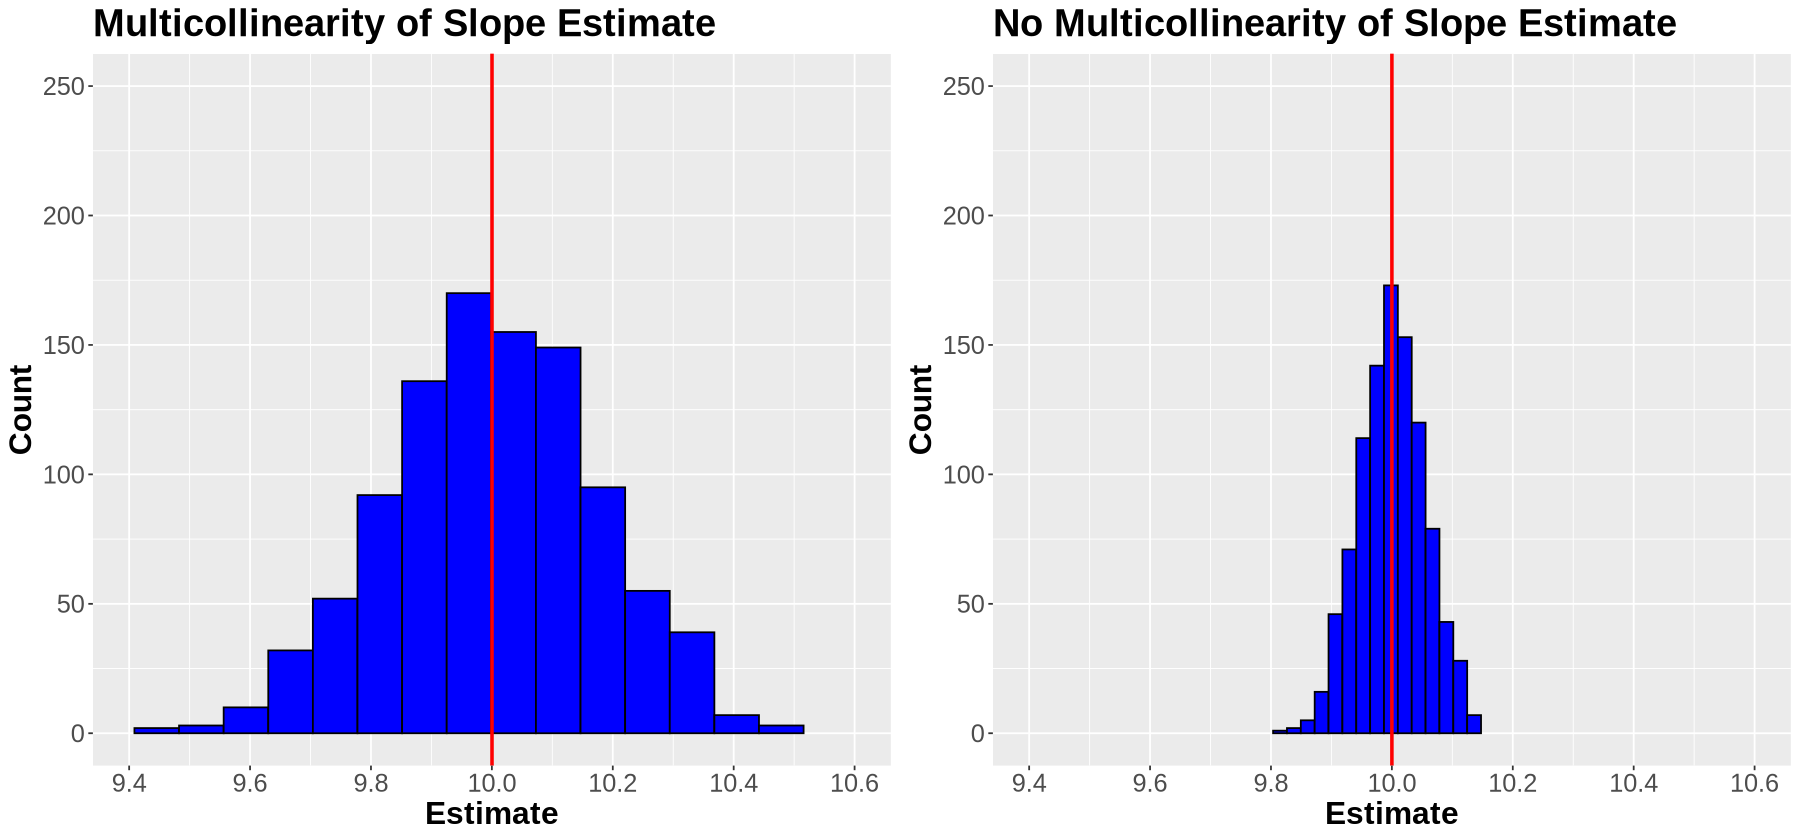

In [38]:
options(repr.plot.width = 15, repr.plot.height = 7) # Adjust these numbers so the plot looks good in your desktop.

# hist_multicollinearity_slope_x_1 <- ggplot(..., aes(...)) +
#   ...(bins = 15, color = "black", fill = "blue") +
#   ...(..., col = "red", size = 1) +
#   coord_cartesian(xlim = c(9.4, 10.6), ylim = c(0, 250)) +
#   scale_x_continuous(breaks = seq(9, 10.6, 0.2)) +
#   xlab(...) +
#   ylab(...) +
#   theme(
#     text = element_text(size = 19),
#     plot.title = element_text(face = "bold"),
#     axis.title = element_text(face = "bold")
#   ) +
#   ggtitle(...)

# hist_no_multicollinearity_slope_x_1 <- ggplot(..., aes(...)) +
#   ...(bins = 15, color = "black", fill = "blue") +
#   ...(..., col = "red", size = 1) +
#   coord_cartesian(xlim = c(9.4, 10.6), ylim = c(0, 250)) +
#   scale_x_continuous(breaks = seq(9, 10.6, 0.2)) +
#   xlab(...) +
#   ylab(...) +
#   theme(
#     text = element_text(size = 19),
#     plot.title = element_text(face = "bold"),
#     axis.title = element_text(face = "bold")
#   ) +
#   ggtitle(...)

# plot_grid(hist_multicollinearity_slope_x_1, hist_no_multicollinearity_slope_x_1,
#   ncol = 2
# )

# your code here
hist_multicollinearity_slope_x_1 <- ggplot(lm_multicollinearity, aes(beta_1_hat)) +
  geom_histogram(bins = 15, color = "black", fill = "blue") +
  geom_vline(aes(xintercept = mean(beta_1_hat)), col = "red", size = 1) +
  coord_cartesian(xlim = c(9.4, 10.6), ylim = c(0, 250)) +
  scale_x_continuous(breaks = seq(9, 10.6, 0.2)) +
  xlab("Estimate") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("Multicollinearity of Slope Estimate")

hist_no_multicollinearity_slope_x_1 <- ggplot(lm_no_multicollinearity, aes(beta_1_hat)) +
  geom_histogram(bins = 15, color = "black", fill = "blue") +
  geom_vline(aes(xintercept = mean(beta_1_hat)), col = "red", size = 1) +
  coord_cartesian(xlim = c(9.4, 10.6), ylim = c(0, 250)) +
  scale_x_continuous(breaks = seq(9, 10.6, 0.2)) +
  xlab("Estimate") +
  ylab("Count") +
  theme(
    text = element_text(size = 19),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("No Multicollinearity of Slope Estimate")

plot_grid(hist_multicollinearity_slope_x_1, hist_no_multicollinearity_slope_x_1,
  ncol = 2
)


In [39]:
test_2.12.0()
test_2.12.1()

Test passed 🥇
Test passed 🎉
Test passed 🥇
Test passed 🥳
Test passed 😀
Test passed 😸
Test passed 😀
Test passed 🎊
[1] "Success!"
Test passed 😸
Test passed 😀
Test passed 🥇
Test passed 😀
Test passed 😀
Test passed 🥳
Test passed 🌈
Test passed 🎊
[1] "Success!"


**Question 2.13**
<br>{points: 1}

Based on your findings in `hist_multicollinearity_slope_x_1` and `hist_no_multicollinearity_slope_x_1`, what are the implications of multicollinearity in the sampling distributions of least squares estimators of MLR?

**A.** The multicollinearity reduces the standard error of the regression estimator.

**B.** Multicollinearity inflates the standard error of the regression estimator.

**C.** Multicollinearity does not seems to affect the estimation results.

*Assign your answer to an object called answer2.13. Your answer should be one of `"A"`, `"B"`, or `"C"` surrounded by quotes.*


In [40]:
# answer2.13 <- ...

# your code here
answer2.13 <- "B"

In [41]:
test_2.13()

Test passed 🌈
Test passed 😸
Test passed 🎉
[1] "Success!"


# PART II

## 2.  Causality and Confounders

You will work on a simulation experiment outlined in `tutorial_05`.